In [6]:
version_nb = "v3"

/Users/joachimjasmin/.pyenv/versions/3.12.10/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:533: UserWarning: The parameter 'ngram_range' will not be used since 'analyzer' is callable'
  warnings.warn(


Final dictionary => 2504 words
Dictionary => {'break': 269, 'first': 891, 'charge': 363, 'file': 877, 'russia': 1941, 'investigation': 1169, 'special': 2095, 'counsel': 518, 'robert': 1925, 'mueller': 1440, 'appear': 129, 'turn': 2336, 'something': 2076, 'scandal': 1960, 'official': 1516, 'accord': 11, 'cnn': 410, 'someone': 2075, 'may': 1364, 'well': 2444, 'take': 2213, 'custody': 555, 'day': 573, 'house': 1074, 'senate': 1996, 'seem': 1991, 'throw': 2269, 'republican': 1871, 'include': 1115, 'trump': 2329, 'call': 308, 'hillary': 1049, 'one': 1525, 'still': 2138, 'exclusive': 809, 'story': 2144, 'currently': 554, 'order': 1542, 'federal': 863, 'judge': 1218, 'office': 1514, 'would': 2482, 'comment': 429, 'however': 1076, 'say': 1957, 'plan': 1635, 'prepared': 1684, 'friday': 937, 'anyone': 120, 'soon': 2079, 'monday': 1422, 'source': 2084, 'unclear': 2352, 'appoint': 133, 'shortly': 2035, 'fire': 889, 'fbi': 858, 'director': 652, 'james': 1193, 'comey': 426, 'original': 1546, 'whethe

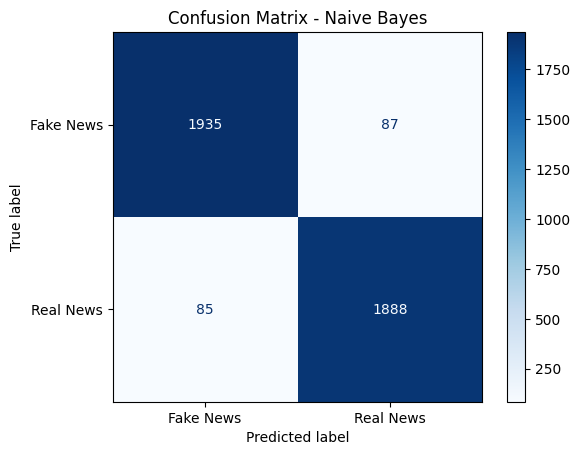

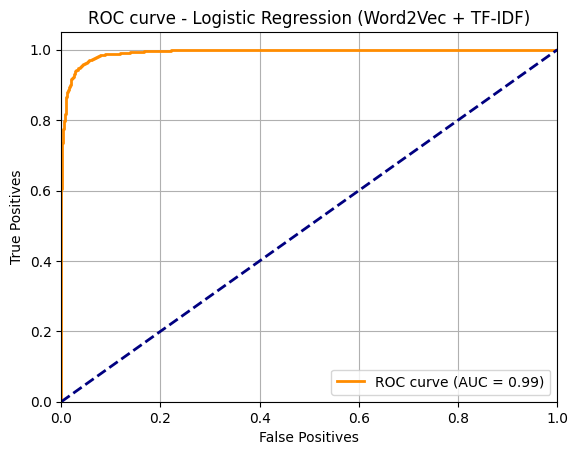

              precision    recall  f1-score   support

   Fake News       0.96      0.96      0.96      2022
   Real News       0.96      0.96      0.96      1973

    accuracy                           0.96      3995
   macro avg       0.96      0.96      0.96      3995
weighted avg       0.96      0.96      0.96      3995

Validation predictions saved to ../data/validation_predictions_v3.csv


In [7]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import re
import nltk
import pandas as pd
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer

# ------------------------------------------------------------------ #
#                        Joined Data cleaning                        #
# ------------------------------------------------------------------ #

df = pd.read_csv("../../dataset/data.csv")

df['combined_text'] = df['title'] + ' ' + df['text'] + ' ' + df['subject']
df.drop(['title', 'text', 'subject', 'date'], axis=1, inplace=True)

# ------------------------------------------------------------------ #
#                          Train-Test Split                          #
# ------------------------------------------------------------------ #

y = df['label']
X = df.drop(['label'], axis=1)['combined_text']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# ------------------------------------------------------------------ #
#                           Pre-Processing                           #
# ------------------------------------------------------------------ #

stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

def pre_token_cleanup(text):
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    text = text.encode('ascii', 'ignore').decode('utf-8')
    return text

def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0]
    tag_dict = {"J": wordnet.ADJ, "N": wordnet.NOUN, "V": wordnet.VERB, "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

def preprocessing_pipeline(text):
    # Pre-token cleaning
    text = pre_token_cleanup(text)
    
    # Tokenization
    tokens = word_tokenize(text, language="english")
    
    # Cleaning steps
    tokens = [word.lower() for word in tokens if word.isalpha()]
    tokens = [word for word in tokens if word not in stop_words]
    
    # Lemmatization
    tokens = [lemmatizer.lemmatize(word, get_wordnet_pos(word)) for word in tokens]
    
    return tokens

X_train = X_train.apply(preprocessing_pipeline)
X_test = X_test.apply(preprocessing_pipeline)

# -------------------------------- . ------------------------------- #
# ------------------------- MODEL TRAINING ------------------------- #
# -------------------------------- . ------------------------------- #

import numpy as np
import matplotlib.pyplot as plt
from gensim.models import Word2Vec
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc, classification_report, accuracy_score
import pickle
import json

# ------------------------------------------------------------------ #
#                              Word2Vec                              #
# ------------------------------------------------------------------ #

w2v_model = Word2Vec(sentences=X_train, vector_size=100, window=5, min_count=1, workers=4)

# ------------------------------------------------------------------ #
#                               TF-IDF                               #
# ------------------------------------------------------------------ #

def identity(x):
    return x

tfidf_vectorizer = TfidfVectorizer(
    analyzer=identity,
    min_df=0.01,
    max_df=0.9,
    ngram_range=(1, 3)
)

# We fit the pre-processed training data
tfidf_vectorizer.fit(X_train)

# Get weights
idf_weights = dict(zip(tfidf_vectorizer.get_feature_names_out(), tfidf_vectorizer.idf_))

# Vizualize
print("Final dictionary =>", len(tfidf_vectorizer.vocabulary_), "words")
print("Dictionary =>", tfidf_vectorizer.vocabulary_)

# ------------------------------------------------------------------ #
#                              Embedding                             #
# ------------------------------------------------------------------ #

def get_weighted_embedding(tokens, model, idf_dict):
    vecs = []
    for word in tokens:
        if word in model.wv and word in idf_dict:
            vecs.append(model.wv[word] * idf_dict[word])
    if vecs:
        return np.mean(vecs, axis=0)
    else:
        return np.zeros(model.vector_size)
    
doc_embeddings_train = np.array([
    get_weighted_embedding(doc, w2v_model, idf_weights)
    for doc in X_train
])

doc_embeddings_test = np.array([
    get_weighted_embedding(doc, w2v_model, idf_weights)
    for doc in X_test
])

# ------------------------------------------------------------------ #
#                         Logistic Regression                        #
# ------------------------------------------------------------------ #

# Logistic Regression
model = LogisticRegression(max_iter=1000, random_state=42)
model.fit(doc_embeddings_train, y_train)

# Prediction
y_pred = model.predict(doc_embeddings_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# ------------------------------------------------------------------ #
#                          Confusion Matrix                          #
# ------------------------------------------------------------------ #

cm = confusion_matrix(y_test, y_pred) # Labels (1 = Real News, 0 = fake News)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Fake News", "Real News"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix - Naive Bayes")
plt.show()

# ------------------------------------------------------------------ #
#                              ROC Curve                             #
# ------------------------------------------------------------------ #


y_proba = model.predict_proba(doc_embeddings_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positives")
plt.ylabel("True Positives")
plt.title("ROC curve - Logistic Regression (Word2Vec + TF-IDF)")
plt.legend(loc="lower right")
plt.grid()
plt.show()

# ------------------------------------------------------------------ #
#                        Classification Report                       #
# ------------------------------------------------------------------ #

# Classification report
print(classification_report(y_test, y_pred, target_names=["Fake News", "Real News"]))

# ------------------------------------------------------------------ #
#                            Model saving                            #
# ------------------------------------------------------------------ #

# Save the model
with open(f"../exports/model_{version_nb}.pkl", "wb") as f:
    pickle.dump(model, f)

# Save the Word2Vec model
w2v_model.save(f"../exports/w2v_model_{version_nb}.model")

# Save the IDF dictionary
with open(f"../exports/idf_dict_{version_nb}.pkl", "wb") as f:
    pickle.dump(idf_weights, f)

# Save the TfidfVectorizer
# with open(f"../exports/vect_{version_nb}.pkl", "wb") as f:
#     pickle.dump(tfidf_vectorizer, f)

# Save the metadata
metadata = {
    "model_name": f"model_{version_nb}",
    "vectorizer": "Word2Vec + TF-IDF (custom)",
    "accuracy": round(accuracy, 4),
    "date": "2025-05-22",
    "preprocessing": {
        "tokenization": "nltk word_tokenize",
        "stopwords": "NLTK english",
        "lemmatization": "WordNet POS-aware",
        "lowercase": True,
        "remove_punctuation": True
    },
    "vectorizer_params": str(tfidf_vectorizer.get_params()),
    "model_params": str(model.get_params())
}
with open(f"../exports/metadata_{version_nb}.json", "w") as f:
    json.dump(metadata, f, indent=4)

# ------------------------------------------------------------------ #
#                             Predicition                            #
# ------------------------------------------------------------------ #

from gensim.models import Word2Vec

with open(f"../exports/model_{version_nb}.pkl", "rb") as f:
    loaded_model = pickle.load(f)

w2v_model = Word2Vec.load(f"../exports/w2v_model_{version_nb}.model")

with open(f"../exports/idf_dict_{version_nb}.pkl", "rb") as f:
    idf_weights = pickle.load(f)

# Load val data
val_df = pd.read_csv("../../dataset/validation_data.csv")
val_df['combined_text'] = val_df['title'] + ' ' + val_df['text'] + ' ' + val_df['subject']
X_val = val_df['combined_text'].apply(preprocessing_pipeline)

doc_embeddings_val = np.array([
    get_weighted_embedding(doc, w2v_model, idf_weights)
    for doc in X_val
])

val_pred = loaded_model.predict(doc_embeddings_val)
val_df['predicted_label'] = val_pred
val_df.to_csv(f"../data/validation_predictions_{version_nb}.csv", index=False)
print(f"Validation predictions saved to ../data/validation_predictions_{version_nb}.csv")